### Item Based

In [1]:
# import shutil

# !wget https://github.com/nzhinusoftcm/review-on-collaborative-filtering/raw/master/recsys.zip    
# shutil.unpack_archive('recsys.zip')

### Import requirements

```
matplotlib==3.2.2
numpy==1.19.2
pandas==1.0.5
python==3.7
scikit-learn==0.24.1
scikit-surprise==1.1.1
scipy==1.6.2
```

In [1]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

from recsys.datasets import ml1m
from recsys.preprocessing import ids_encoder

import pandas as pd
import numpy as np
import os
import sys

### Load ratings

In [2]:
ratings, movies = ml1m.load()

### userids and itemids encoding

In [3]:
# create the encoder
ratings, uencoder, iencoder = ids_encoder(ratings)

Let's implements the item-based collaborative filtering algorithm described above

To compute similarity between two items $i$ and $j$, we need to :

1. find all users who rated both of them,
2. Normalize their ratings on items $i$ and $j$
3. Apply the cosine metric to the normalized ratings to compute similarity between $i$ and $j$

Function ```normalize()``` process the rating dataframe to normalize ratings of all users

In [4]:
def normalize():
    # compute mean rating for each user
    mean = ratings.groupby(by='userid', as_index=False)['rating'].mean()
    norm_ratings = pd.merge(ratings, mean, suffixes=('','_mean'), on='userid')
    
    # normalize each rating by substracting the mean rating of the corresponding user
    norm_ratings['norm_rating'] = norm_ratings['rating'] - norm_ratings['rating_mean']
    return mean.to_numpy()[:, 1], norm_ratings

In [5]:
mean, norm_ratings = normalize()
np_ratings = norm_ratings.to_numpy()
norm_ratings.head()

,userid,itemid,rating,rating_mean,norm_rating
0,0,0,5,4.188679,0.811321
1,0,47,5,4.188679,0.811321
2,0,144,5,4.188679,0.811321
3,0,253,4,4.188679,-0.188679
4,0,513,5,4.188679,0.811321


now that each rating has been normalized, we can represent each item by a vector of its normalized ratings

In [6]:
def item_representation(ratings):    
    return csr_matrix(
        pd.crosstab(ratings.itemid, ratings.userid, ratings.norm_rating, aggfunc=sum).fillna(0).values
    )

In [7]:
R = item_representation(norm_ratings)

Let's build and fit our $k$-NN model using sklearn

In [8]:
def create_model(rating_matrix, k=20, metric="cosine"):
    """
    :param R : numpy array of item representations
    :param k : number of nearest neighbors to return    
    :return model : our knn model
    """    
    model = NearestNeighbors(metric=metric, n_neighbors=k+1, algorithm='brute')
    model.fit(rating_matrix)    
    return model

#### Similarities computation

Similarities between items can be measured with the *Cosine* or *Eucliedian* distance. The ***NearestNeighbors*** class from the sklearn library simplifies the computation of neighbors. We just need to specify the metric (e.g. cosine or euclidian) that will be used to compute similarities.

The above method, ```create_model```, creates the kNN model and the following ```nearest_neighbors``` method uses the created model to kNN items. It returns nearest neighbors as well as similarities measures for each items.

```nearest_neighbors``` returns :
- ```similarities``` : numpy array of shape $(n,k)$
- ```neighbors``` : numpy array of shape $(n,k)$

where $n$ is the total number of items and $k$ is the number of neighbors to return, specified when creating the kNN model.

In [9]:
def nearest_neighbors(rating_matrix, model):
    """
    compute the top n similar items for each item.    
    :param rating_matrix : items representations
    :param model : nearest neighbors model    
    :return similarities, neighbors
    """    
    similarities, neighbors = model.kneighbors(rating_matrix)    
    return similarities[:,1:], neighbors[:,1:]

This term is computed for all users $u\in U$, where $U$ is the set of users that rated both items $i$ and $j$. Since the *sklearn* library do not directly implement the adjusted cosine similarity metric, we will implement it with the method ```adjusted_cosine```, with some helper function :

- ```save_similarities``` : since the computation of the adjusted cosine similarity is time consuming, around 5 mins for the ml100k dataset, we use this method to save the computed similarities for lated usage.
- ```load_similarities``` : load the saved similarities
- ```cosine``` : cosine distance between two vectors.

In [10]:
def save_similarities(similarities, neighbors, dataset_name):    
    base_dir = 'recsys/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)
    os.makedirs(save_dir, exist_ok=True)    
    similarities_file_name = os.path.join(save_dir, 'similarities.npy')
    neighbors_file_name = os.path.join(save_dir, 'neighbors.npy')    
    try:
        np.save(similarities_file_name, similarities)
        np.save(neighbors_file_name, neighbors)        
    except ValueError as error:
        print(f"An error occured when saving similarities, due to : \n ValueError : {error}")

        
def load_similarities(dataset_name, k=20):
    base_dir = 'recsys/weights/item2item'
    save_dir = os.path.join(base_dir, dataset_name)    
    similiraties_file = os.path.join(save_dir, 'similarities.npy')
    neighbors_file = os.path.join(save_dir, 'neighbors.npy')    
    similarities = np.load(similiraties_file)
    neighbors = np.load(neighbors_file)    
    return similarities[:,:k], neighbors[:,:k]


def cosine(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))


def adjusted_cosine(np_ratings, nb_items, dataset_name):
    similarities = np.zeros(shape=(nb_items, nb_items))
    similarities.fill(-1)
    
    def _progress(count):
        sys.stdout.write('\rComputing similarities. Progress status : %.1f%%' % (float(count / nb_items)*100.0))
        sys.stdout.flush()
        
    items = sorted(ratings.itemid.unique())    
    for i in items[:-1]:
        for j in items[i+1:]:            
            scores = np_ratings[(np_ratings[:, 1] == i) | (np_ratings[:, 1] == j), :]
            vals, count = np.unique(scores[:,0], return_counts = True)
            scores = scores[np.isin(scores[:,0], vals[count > 1]),:]

            if scores.shape[0] > 2:
                x = scores[scores[:, 1].astype('int') == i, 4]
                y = scores[scores[:, 1].astype('int') == j, 4]
                w = cosine(x, y)

                similarities[i, j] = w
                similarities[j, i] = w
        _progress(i)
    _progress(nb_items)
    
    # get neighbors by their neighbors in decreasing order of similarities
    neighbors = np.flip(np.argsort(similarities), axis=1)
    
    # sort similarities in decreasing order
    similarities = np.flip(np.sort(similarities), axis=1)
    
    # save similarities to disk
    save_similarities(similarities, neighbors, dataset_name=dataset_name) 
    
    return similarities, neighbors

now, we can call the ```adjusted_cosine``` function to compute and save items similarities and neighbors based on the adjusted cosine metric. 

uncomment the two lines of the following cell to compute the adjusted cosine between all items. As we have already run the next cell before, we will just load the precomputed similarities for further use.

In [11]:
# nb_items = ratings.itemid.nunique()
# similarities, neighbors = adjusted_cosine(np_ratings, nb_items=nb_items, dataset_name='ml100k')

Among the following similarity metrics, choose the one you wish to use for the item-based collaborative filtering :

- **euclidian** or **cosine** : choose *euclidian* or *cosine* to initialise the similarity model through the sklearn library.
- **adjusted_cosine** : choose the *adjusted_cosine* metric to load similarities computed and saved through the ```adjusted_cosine``` function.

In this case, we will use the *adjusted_cosine* metric.

In [12]:
# metric : choose among [cosine, euclidean, adjusted_cosine]

metric = 'adjusted_cosine'

if metric == 'adjusted_cosine':
    similarities, neighbors = load_similarities('ml1m')
else:
    model = create_model(R, k=21, metric=metric)
    similarities, neighbors = nearest_neighbors(R, model)

In [13]:
print('neighbors shape : ', neighbors.shape)
print('similarities shape : ', similarities.shape)

neighbors shape :  (3706, 20)
similarities shape :  (3706, 20)


```neighbors``` and ```similarities``` are numpy array, were each entries are list of 20 neighbors with their corresponding similarities

Top-N recommendations are made for example for a user $u$ who has already rated a set of items $I_u$

#### 2.a- Finding candidate items

To find candidate items for user $u$, we need to :

1. Find the set $I_u$ of items already rated by user $u$,
2. Take the union of similar items as $C$ for all items in $I_u$
3. exclude from the set $C$ all items in $I_u$, to avoid recommend to a user items he has already purchased.

These are done in function ```candidate_items()```

In [14]:
# def candidate_items(userid):
#     """
#     :param userid : user id for which we wish to find candidate items    
#     :return : I_u, candidates
#     """
    
#     # 1. Finding the set I_u of items already rated by user userid
#     I_u = np_ratings[np_ratings[:, 0] == userid]
#     I_u = I_u[:, 1].astype('int')
    
#     # 2. Taking the union of similar items for all items in I_u to form the set of candidate items
#     c = set()
        
#     for iid in I_u:    
#         # add the neighbors of item iid in the set of candidate items
#         c.update(neighbors[iid])
        
#     c = list(c)
#     # 3. exclude from the set C all items in I_u.
#     candidates = np.setdiff1d(c, I_u, assume_unique=True)
    
#     return I_u, candidates


def candidate_items(userid):
    """
    :param userid : user id for which we wish to find candidate items    
    :return : I_u, candidates
    """
    
    # 1. Finding the set I_u of items already rated by user userid
    I_u = np_ratings[np_ratings[:, 0] == userid]
    I_u = I_u[:, 1].astype('int')
    
    # 2. Taking the union of similar items for all items in I_u to form the set of candidate items
    c = set()
        
    for iid in I_u:
        try:
            # add the neighbors of item iid in the set of candidate items
            c.update(neighbors[iid])
        except IndexError:
            # Handle the IndexError and continue to the next item
            pass
    
    c = list(c)
    # 3. exclude from the set C all items in I_u.
    candidates = np.setdiff1d(c, I_u, assume_unique=True)
    
    return I_u, candidates


In [15]:
test_user = uencoder.transform([9])[0]
i_u, u_candidates = candidate_items(test_user)

In [16]:
print('number of items purchased by user 1 : ', len(i_u))
print('number of candidate items for user 1 : ', len(u_candidates))

number of items purchased by user 1 :  106
number of candidate items for user 1 :  604


#### 2.b- Find similarity between each candidate item and the set $I_u$

In [17]:
# def similarity_with_Iu(c, I_u):
#     """
#     compute similarity between an item c and a set of items I_u. For each item i in I_u, get similarity between 
#     i and c, if c exists in the set of items similar to itemid.    
#     :param c : itemid of a candidate item
#     :param I_u : set of items already purchased by a given user    
#     :return w : similarity between c and I_u
#     """
#     w = 0    
#     for iid in I_u :        
#         # get similarity between itemid and c, if c is one of the k nearest neighbors of itemid
#         if c in neighbors[iid] :
#             w = w + similarities[iid, neighbors[iid] == c][0]    
#     return w

def similarity_with_Iu(c, I_u):
    """
    compute similarity between an item c and a set of items I_u. For each item i in I_u, get similarity between 
    i and c, if c exists in the set of items similar to itemid.    
    :param c : itemid of a candidate item
    :param I_u : set of items already purchased by a given user    
    :return w : similarity between c and I_u
    """
    w = 0    
    for iid in I_u:
        try:
            # get similarity between itemid and c, if c is one of the k nearest neighbors of itemid
            if c in neighbors[iid]:
                w = w + similarities[iid, neighbors[iid] == c][0]
        except IndexError:
            # Handle the IndexError and continue to the next item in I_u
            pass
    return w


#### 2.c- Rank candidate items according to their similarities to $I_u$

In [18]:
def rank_candidates(candidates, I_u):
    """
    rank candidate items according to their similarities with i_u    
    :param candidates : list of candidate items
    :param I_u : list of items purchased by the user    
    :return ranked_candidates : dataframe of candidate items, ranked in descending order of similarities with I_u
    """
    
    # list of candidate items mapped to their corresponding similarities to I_u
    sims = [similarity_with_Iu(c, I_u) for c in candidates]
    candidates = iencoder.inverse_transform(candidates)    
    mapping = list(zip(candidates, sims))
    
    ranked_candidates = sorted(mapping, key=lambda couple:couple[1], reverse=True)    
    return ranked_candidates

## Putting all together

Now that we defined all functions necessary to build our item to item top-N recommendation, let's define function ```item2item_topN()``` that makes top-$N$ recommendations for a given user 

In [19]:
def topn_recommendation(userid, N=30):
    """
    Produce top-N recommendation for a given user    
    :param userid : user for which we produce top-N recommendation
    :param n : length of the top-N recommendation list    
    :return topn
    """
    # find candidate items
    I_u, candidates = candidate_items(userid)
    
    # rank candidate items according to their similarities with I_u
    ranked_candidates = rank_candidates(candidates, I_u)
    
    # get the first N row of ranked_candidates to build the top N recommendation list
    topn = pd.DataFrame(ranked_candidates[:N], columns=['itemid','similarity_with_Iu'])    
    topn = pd.merge(topn, movies, on='itemid', how='inner')    
    return topn

In [20]:
topn_recommendation(test_user)

,itemid,similarity_with_Iu,title,genres
0,2811,36.965011,With Friends Like These... (1998),Comedy
1,3517,32.210196,"Bells, The (1926)",Crime|Drama
2,3443,22.754787,Born American (1986),Action|Drama|Thriller
3,3380,20.499962,Railroaded! (1947),Film-Noir
4,787,19.186551,"Gate of Heavenly Peace, The (1995)",Documentary
5,3245,19.047381,I Am Cuba (Soy Cuba/Ya Kuba) (1964),Drama
6,167,19.028066,Feast of July (1995),Drama
7,1002,17.774802,Ed's Next Move (1996),Comedy
8,755,17.327337,Kim (1950),Children's|Drama
9,1149,17.018185,JLG/JLG - autoportrait de décembre (1994),Documentary|Drama


This dataframe represents the top N recommendation list a user. These items are sorted in decreasing order of similarities with $I_u$.

**Observation** : The recommended items are the most similar to the set $I_u$ of items already purchased by the user.

## Top N recommendation with predictions

Before recommending the previous list to the user, we can go further and predict the ratings the user would have given to each of these items, sort them in descending order of prediction and return the reordered list as the new top N recommendation list.

### Rating prediction

As stated earlier, the predicted rating $\hat{r}_{u,i}$ for a given user $u$ on an item $i$ is obtained by aggregating ratings given by $u$ on items similar to $i$ as follows:

\begin{equation}
 \hat{r}_{u,i}=\frac{\sum_{j\in S^{(i)}}r_{u,j}\cdot w_{i,j}}{\sum_{j\in S^{(i)}}|w_{i,j}|}
\end{equation}

In [21]:
# def predict(userid, itemid):
#     """
#     Make rating prediction for user userid on item itemid    
#     :param userid : id of the active user
#     :param itemid : id of the item for which we are making prediction        
#     :return r_hat : predicted rating
#     """
    
#     # Get items similar to item itemid with their corresponding similarities
#     item_neighbors = neighbors[itemid]
#     item_similarities = similarities[itemid]
    
#     # get ratings of user with id userid
#     uratings = np_ratings[np_ratings[:, 0].astype('int') == userid]
    
#     # similar items rated by item the user of i
#     siru = uratings[np.isin(uratings[:, 1], item_neighbors)]
#     scores = siru[:, 2]
#     indexes = [np.where(item_neighbors == iid)[0][0] for iid in siru[:,1].astype('int')]    
#     sims = item_similarities[indexes]
    
#     dot = np.dot(scores, sims)
#     som = np.sum(np.abs(sims))

#     if dot == 0 or som == 0:
#         return mean[userid]
    
#     return dot / som


def predict(userid, itemid):
    """
    Make rating prediction for user userid on item itemid    
    :param userid : id of the active user
    :param itemid : id of the item for which we are making prediction        
    :return r_hat : predicted rating
    """
    try:
        # Get items similar to item itemid with their corresponding similarities
        item_neighbors = neighbors[itemid]
        item_similarities = similarities[itemid]
    except IndexError:
        # Handle the IndexError when itemid is not found in neighbors
        return mean[userid]
   
    # get ratings of user with id userid
    uratings = np_ratings[np_ratings[:, 0].astype('int') == userid]
    
    # similar items rated by item the user of i
    siru = uratings[np.isin(uratings[:, 1], item_neighbors)]
    scores = siru[:, 2]
    indexes = [np.where(item_neighbors == iid)[0][0] for iid in siru[:,1].astype('int')]    
    sims = item_similarities[indexes]
    
    dot = np.dot(scores, sims)
    som = np.sum(np.abs(sims))

    if dot == 0 or som == 0:
        return mean[userid]
    
    return dot / som

Now let's use our ```predict()``` function to predict what ratings the user would have given to the previous top-$N$ list and return the reorganised list (in decreasing order of predictions) as the new top-$N$ list

In [22]:
def topn_prediction(userid):
    """
    :param userid : id of the active user    
    :return topn : initial topN recommendations returned by the function item2item_topN
    :return topn_predict : topN recommendations reordered according to rating predictions
    """
    # make top N recommendation for the active user
    topn = topn_recommendation(userid)
    
    # get list of items of the top N list
    itemids = topn.itemid.to_list()
    
    predictions = []
    
    # make prediction for each item in the top N list
    for itemid in itemids:
        r = predict(userid, itemid)
        
        predictions.append((itemid,r))
    
    predictions = pd.DataFrame(predictions, columns=['itemid','prediction'])
    
    # merge the predictions to topN_list and rearrange the list according to predictions
    topn_predict = pd.merge(topn, predictions, on='itemid', how='inner')
    topn_predict = topn_predict.sort_values(by=['prediction'], ascending=False)
    
    return topn, topn_predict

Now, let's make recommendation for user 1 and compare the two list

In [23]:
users = ratings.userid.unique()
users

array([   0,    1,    2, ..., 6037, 6038, 6039])

In [24]:
# uncomment this to generate predictions for all users
# preds = []
# for user in users:
#     _, topn_predict = topn_prediction(userid=user)
#     preds.append(topn_predict)

In [25]:
# len(users)

In [26]:
# len(preds)

In [27]:
# for i in range(len(users)):
#     # preds[i]['userid'] = users[i]
#     # preds[i]['prediction'] = preds[i].prediction.abs()
#     preds[i] = preds[i].sort_values(by=['prediction'], ascending=False)

In [28]:
# df = pd.concat(preds).reset_index(drop=True)

In [29]:
# df.columns

In [30]:
# df[['userid', 'itemid', 'similarity_with_Iu', 'title', 'genres', 'prediction']].to_csv('item_based_predictions_with_genres.csv', index = False)

In [31]:
test_user

8

In [32]:
topn, topn_predict = topn_prediction(userid=test_user)

In [33]:
topn_predict

,itemid,similarity_with_Iu,title,genres,prediction
7,1002,17.774802,Ed's Next Move (1996),Comedy,4.000000
0,2811,36.965011,With Friends Like These... (1998),Comedy,3.735849
16,1160,13.268611,Six of a Kind (1934),Comedy,3.735849
28,2999,11.149107,Man of the Century (1999),Comedy,3.735849
27,578,11.454941,"Hour of the Pig, The (1993)",Drama|Mystery,3.735849
26,3242,11.797776,Santitos (1997),Comedy,3.735849
25,37,11.917839,Across the Sea of Time (1995),Documentary,3.735849
24,2825,12.085077,Rosie (1998),Drama,3.735849
23,560,12.224856,"Beans of Egypt, Maine, The (1994)",Drama,3.735849
22,3292,12.334062,"Big Combo, The (1955)",Film-Noir,3.735849


As you will have noticed, the two lists are sorted in different ways. The second list is organized according to the predictions made for the user.

<b>Note</b>: When making predictions for user $u$ on item $i$, user $u$ may not have rated any of the $k$ most similar items to i. In this case, we consider the mean rating of $u$ as the predicted value.

## Evaluation with Mean Absolute Error

In [34]:
def calculate_ndcg(actual, recommended):
    dcg = 0
    for i in range(len(recommended)):
        item = recommended[i]
        if item in actual:
            dcg += 1 / np.log2(i + 2)  # Index starts at 0, so add 2
    idcg = sum(1 / np.log2(i + 2) for i in range(len(actual)))
    ndcg = dcg / idcg
    return ndcg

In [35]:
from recsys.preprocessing import train_test_split, get_examples

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

# def evaluate(x_test, y_test):
#     print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
#     preds = list(predict(u,i) for (u,i) in x_test)
#     mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
#     print('\nMAE :', mae)
#     return mae

from recsys.preprocessing import train_test_split, get_examples
from sklearn.metrics import precision_score, recall_score

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

def evaluate(x_test, y_test):
    print('Evaluate the model on {} test data ...'.format(x_test.shape[0]))
    preds = list(predict(u,i) for (u,i) in x_test)
    mae = np.sum(np.absolute(y_test - np.array(preds))) / x_test.shape[0]
    print('\nMAE :', mae)

    precision = precision_score(y_test, list(map(int, preds)), average='micro')
    print(f"Precision: {precision:.4f}")
    
    recall = recall_score(y_test, list(map(int, preds)), average='micro')
    print(f"Recall: {recall:.4f}")
    
    ndcg = calculate_ndcg(y_test, list(map(int, preds)))
    print(f"Ndcg: {ndcg:.4f}")

    
    # return mae

In [36]:
evaluate(x_test, y_test)

Evaluate the model on 100021 test data ...

MAE : 0.767559125308571
Precision: 0.3374
Recall: 0.3374
Ndcg: 0.9998


In [5]:
# item_preds_df = pd.read_csv('item_based_predictions_with_genres.csv')[['genres', 'prediction']]
# user_preds_df = pd.read_csv('user_based_predictions_with_genres.csv')[['genres', 'predicted_rating']]
mf_preds_df = pd.read_csv('MF_predictions_with_genres.csv')[['genres', 'score']]

In [23]:
import pandas as pd

def compute_genre_distr(items_df):
    """Compute the genre distribution for a given DataFrame of items."""
    distr = {}

    for index, row in items_df.iterrows():
        genre = row['genres']
        # score = row['rating']
        # score = row['predicted_rating']
        score = row['score']

        genre_score = distr.get(genre, 0.)
        distr[genre] = genre_score + score

    # normalize the summed-up probability so it sums up to 1
    # round it to three decimal places for added precision
    for genre, genre_score in distr.items():
        normed_genre_score = round(genre_score / len(items_df), 3)
        distr[genre] = normed_genre_score

    return distr

In [24]:
# recommended_distr = compute_genre_distr(item_preds_df)
# recommended_distr = compute_genre_distr(user_preds_df)
recommended_distr = compute_genre_distr(mf_preds_df)

In [10]:
items_interacted_df = pd.merge(ratings, movies, on='itemid', how='inner')[['genres', 'rating']]

In [14]:
interacted_distr = compute_genre_distr(items_interacted_df)

In [15]:
def replace_zero_with_small_value(input_dict, small_value=0.0001):
    """Replace all occurrences of 0 with a small_value in a dictionary."""
    return {key: small_value if value == 0 else value for key, value in input_dict.items()}

# Example usage:
original_dict = {'A': 0, 'B': 0.002, 'C': 0.005, 'D': 0}

interacted_distr = replace_zero_with_small_value(interacted_distr)
recommended_distr = replace_zero_with_small_value(recommended_distr)

In [18]:
def compute_kl_divergence(interacted_distr, reco_distr, alpha=0.01):
    """
    KL (p || q), the lower the better.

    alpha is not really a tuning parameter, it's just there to make the
    computation more numerically stable.
    """
    kl_div = 0.
    for genre, score in interacted_distr.items():
        reco_score = reco_distr.get(genre, 0.)
        reco_score = (1 - alpha) * reco_score + alpha * score
        kl_div += score * np.log2(score / reco_score)

    return kl_div

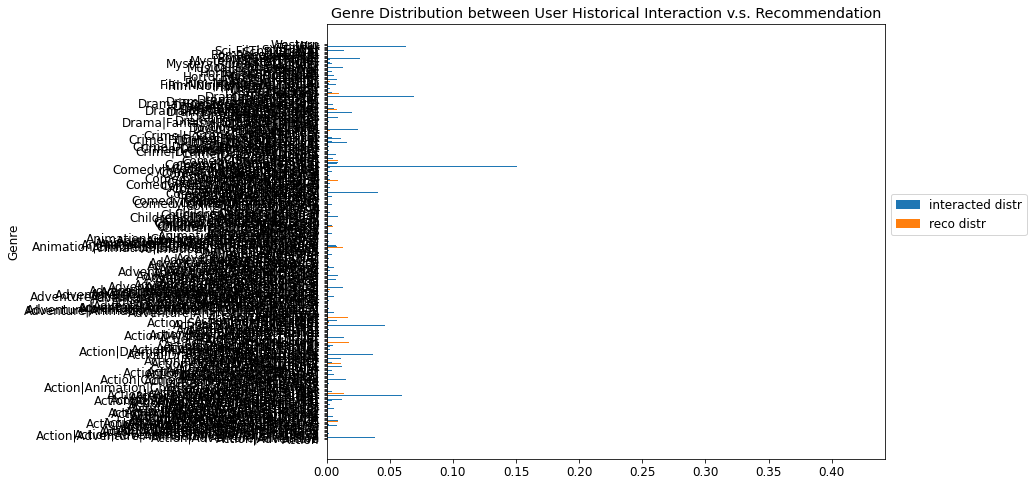

In [16]:
# change default style figure and font size
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


def distr_comparison_plot(interacted_distr, reco_distr, width=0.3):
    
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index')
    reco = pd.DataFrame.from_dict(reco_distr, orient='index')
    df = interacted.join(reco, how='outer', lsuffix='_interacted')

    n = df.shape[0]
    index = np.arange(n)
    plt.barh(index, df['0_interacted'], height=width, label='interacted distr')
    plt.barh(index + width, df['0'], height=width, label='reco distr')
    plt.yticks(index, df.index)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title('Genre Distribution between User Historical Interaction v.s. Recommendation')
    plt.ylabel('Genre')
    plt.show()
    
    
distr_comparison_plot(interacted_distr, recommended_distr)

In [20]:
compute_kl_divergence(interacted_distr, recommended_distr)

15.450573841999976

In [83]:
compute_kl_divergence(interacted_distr, recommended_distr)

0.2730957213259282

In [25]:
compute_kl_divergence(interacted_distr, recommended_distr)

15.543525995381147

In [ ]:
import pandas as pd
from recsys.datasets import ml1m


def compute_genre_distr(items_df):
    """Compute the genre distribution for a given DataFrame of items."""
    distr = {}

    for index, row in items_df.iterrows():
        genre = row['genres']
        score = row['rating']
        # score = row['predicted_rating']
        # score = row['score']

        genre_score = distr.get(genre, 0.)
        distr[genre] = genre_score + score

    # normalize the summed-up probability so it sums up to 1
    # round it to three decimal places for added precision
    for genre, genre_score in distr.items():
        normed_genre_score = round(genre_score / len(items_df), 3)
        distr[genre] = normed_genre_score

    return distr


def replace_zero_with_small_value(input_dict, small_value=0.0001):
    """Replace all occurrences of 0 with a small_value in a dictionary."""
    return {key: small_value if value == 0 else value for key, value in input_dict.items()}


def compute_kl_divergence(interacted_distr, reco_distr, alpha=0.01):
    """
    KL (p || q), the lower the better.

    alpha is not really a tuning parameter, it's just there to make the
    computation more numerically stable.
    """
    kl_div = 0.
    for genre, score in interacted_distr.items():
        reco_score = reco_distr.get(genre, 0.)
        reco_score = (1 - alpha) * reco_score + alpha * score
        kl_div += score * np.log2(score / reco_score)

    return kl_div


ratings, movies = ml1m.load()
items_interacted_df = pd.merge(ratings, movies, on='itemid', how='inner')[['genres', 'rating']]

item_preds_df = pd.read_csv('item_based_predictions_with_genres.csv')[['genres', 'prediction']]
user_preds_df = pd.read_csv('user_based_predictions_with_genres.csv')[['genres', 'predicted_rating']]
mf_preds_df = pd.read_csv('MF_predictions_with_genres.csv')[['genres', 'score']]

interacted_distr = compute_genre_distr(items_interacted_df)

# recommended_distr = compute_genre_distr(item_preds_df)
# recommended_distr = compute_genre_distr(user_preds_df)
recommended_distr = compute_genre_distr(mf_preds_df)

interacted_distr = replace_zero_with_small_value(interacted_distr)
recommended_distr = replace_zero_with_small_value(recommended_distr)

compute_kl_divergence(interacted_distr, recommended_distr)

As with the User-based CF, we have also summarised the Item-based CF into the python class [ItemToItem](https://github.com/nzhinusoftcm/review-on-collaborative-filtering/blob/master/recsys/memories/ItemToItem.py). 

#### ItemToItem : usage

In [37]:
from recsys.memories.ItemToItem import ItemToItem
from recsys.preprocessing import ids_encoder, train_test_split, get_examples
from recsys.datasets import ml1m

# load data
ratings, movies = ml1m.load()

# prepare data
ratings, uencoder, iencoder = ids_encoder(ratings)

# get examples as tuples of userids and itemids and labels from normalize ratings
raw_examples, raw_labels = get_examples(ratings, labels_column='rating')

# train test split
(x_train, x_test), (y_train, y_test) = train_test_split(examples=raw_examples, labels=raw_labels)

#### Instanciate the ItemToItem CF

Parameters :
- ```k``` : number of neighbors to consider for each item
- ```metric``` : metric to use when computing similarities : let's use **cosine**
- ```dataset_name``` : in this example, we use the ml100k dataset

In [38]:
# create the Item-based CF
item2item = ItemToItem(ratings, movies, k=20, metric='cosine', dataset_name='ml1m')

Normalize ratings ...
Create the similarity model ...
Compute nearest neighbors ...
Item to item recommendation model created with success ...


In [39]:
# evaluate the algorithm on test dataset
item2item.evaluate(x_test, y_test)

Evaluate the model on 100021 test data ...

MAE : 0.42514728655396045
Precision: 0.6365
Recall: 0.6365
Ndcg: 0.4883


0.42514728655396045

#### Evaluate the Item-based CF on the ML-1M dataset